In [1]:
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels as sm
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, learning_curve

pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', '{:,.3f}'.format)

import sys
sys.path.append("../src")
import process_data as process

In [2]:
df = process.load_data('../data/raw/advertising.csv')
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.950,35,"61,833.900",256.090,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.230,31,"68,441.850",193.770,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.470,26,"59,785.940",236.500,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.150,29,"54,806.180",245.890,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.370,35,"73,889.990",225.580,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [3]:
X_features = ['Age', 'Area Income'] #, 'Daily Internet Usage'] #, 'Male']
X = df[X_features]
y = df['Clicked on Ad']

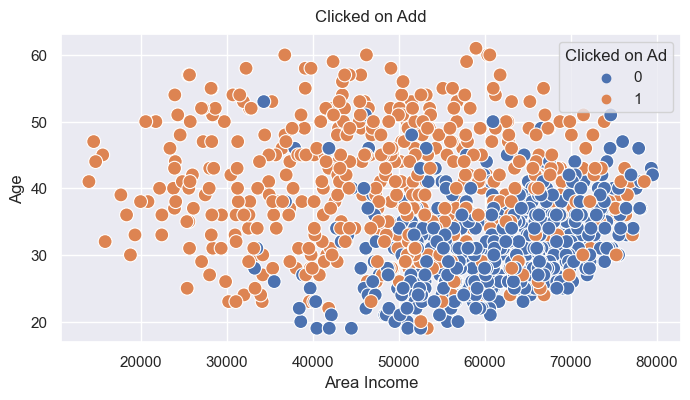

In [4]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Area Income', y='Age', hue='Clicked on Ad', data=df, s=100)
plt.title("Clicked on Add", y=1.015)
plt.ylabel("Age")
ax = plt.gca()

In [5]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_train, x_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=80)
# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=80)

# Initialize the class
scaler = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler.fit_transform(x_train)


In [6]:
clf_model = SGDClassifier(loss='log_loss', penalty='l2')
clf_model.fit(X_train_scaled, y_train)

print(f"number of iterations completed: {clf_model.n_iter_}, number of weight updates: {clf_model.t_}")

b_norm = clf_model.intercept_
w_norm = clf_model.coef_
print(f"model parameters: \n\tw: {w_norm}, b:{b_norm}")

yhat = clf_model.predict(X_train_scaled)
print(f"training MSE (using SGDClassifier): {mean_squared_error(y_train, yhat) / 2}")


number of iterations completed: 44, number of weight updates: 26401.0
model parameters: 
	w: [[ 1.87726543 -1.32166012]], b:[0.5960048]
training MSE (using SGDClassifier): 0.10666666666666667


In [7]:
# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_scaled = scaler.transform(x_cv)
# Feed the scaled cross validation set
yhat = clf_model.predict(X_cv_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Cross validation MSE: 0.085


In [8]:
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

print(f"number of iterations completed: {lr_model.n_iter_}")

b_norm = lr_model.intercept_
w_norm = lr_model.coef_
print(f"model parameters:   \n\tw: {w_norm}, b:{b_norm}")

y_pred = lr_model.predict(X_train_scaled)
print(f"training MSE (using logistic regression function): {mean_squared_error(y_train, y_pred) / 2}")

number of iterations completed: [8]
model parameters:   
	w: [[ 1.38258257 -1.26639644]], b:[0.18886723]
training MSE (using logistic regression function): 0.09833333333333333


In [9]:
# Feed the scaled cross validation set
yhat = lr_model.predict(X_cv_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Cross validation MSE: 0.0925


In [10]:
def plot_train_cv_mses(degrees, train_mses, cv_mses, title):
    degrees = range(1,11)
    plt.plot(degrees, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(degrees, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.title(title)
    plt.xlabel("degree"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()

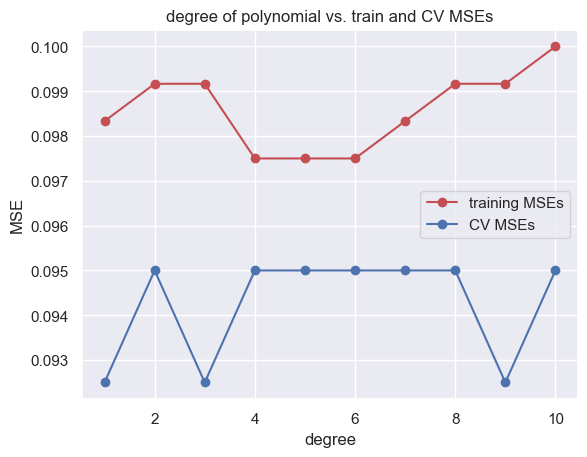

In [11]:
from sklearn.preprocessing import PolynomialFeatures
# Initialize lists containing the lists, models, and scalers
train_mses = []
cv_mses = []
models = []
scalers = []

# Loop over 10 times. Each adding one more degree of polynomial higher than the last.
for degree in range(1,11):
    
    # Add polynomial features to the training set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_train_mapped = poly.fit_transform(x_train)
    
    # Scale the training set
    scaler_poly = StandardScaler()
    X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
    scalers.append(scaler_poly)
    
    # Create and train the model
    model = LogisticRegression()
    model.fit(X_train_mapped_scaled, y_train )
    models.append(model)
    
    # Compute the training MSE
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    train_mses.append(train_mse)
    
    # Add polynomial features and scale the cross validation set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_cv_mapped = poly.fit_transform(x_cv)
    X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)
    
    # Compute the cross validation MSE
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    cv_mses.append(cv_mse)
    
# Plot the results
degrees=range(1,11)
plot_train_cv_mses(degrees, train_mses, cv_mses, title="degree of polynomial vs. train and CV MSEs")

In [12]:
import numpy as np
# Get the model with the lowest CV MSE (add 1 because list indices start at 0)
# This also corresponds to the degree of the polynomial added
degree = np.argmin(cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree={degree}")

Lowest CV MSE is found in the model with degree=1


In [13]:
# Add polynomial features to the test set
poly = PolynomialFeatures(degree, include_bias=False)
X_test_mapped = poly.fit_transform(x_test)

# Scale the test set
X_test_mapped_scaled = scalers[degree-1].transform(X_test_mapped)

# Compute the test MSE
yhat = models[degree-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Training MSE: {train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

Training MSE: 0.10
Cross Validation MSE: 0.09
Test MSE: 0.09


In [14]:
def train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=None):
    
    train_mses = []
    cv_mses = []
    models = []
    scalers = []
    degrees = range(1,max_degree+1)

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for degree in degrees:

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model = LogisticRegression()
        model.fit(X_train_mapped_scaled, y_train )
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    plt.plot(degrees, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(degrees, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.plot(degrees, np.repeat(baseline, len(degrees)), linestyle='--', label='baseline')
    plt.title("degree of polynomial vs. train and CV MSEs")
    plt.xticks(degrees)
    plt.xlabel("degree"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()

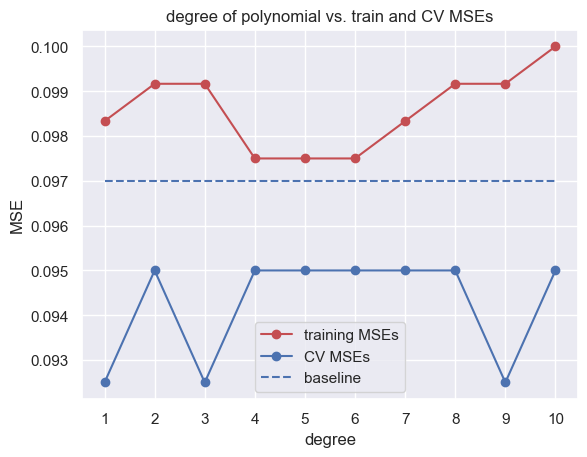

In [15]:
train_plot_poly(model, x_train, y_train, x_cv, y_cv, max_degree=10, baseline=0.097)

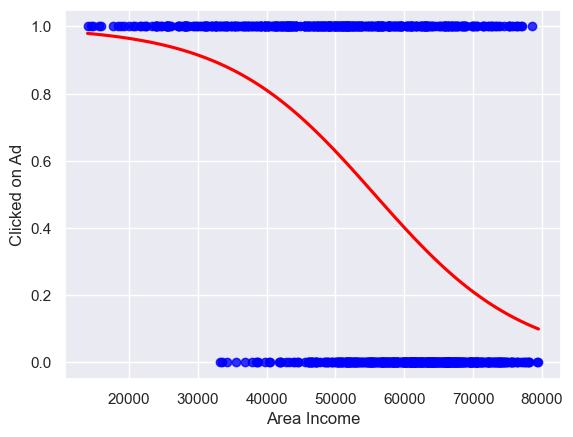

In [16]:
# plot logistic regression curve with black points and red line
sns.regplot(x=df['Area Income'], y=df['Clicked on Ad'], data=df, logistic=True, ci=None,
            scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.show()

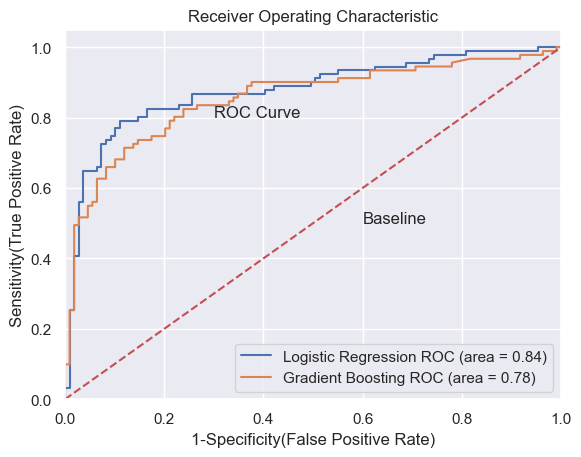

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [{'label': 'Logistic Regression', 'model': LogisticRegression()},
{'label': 'Gradient Boosting', 'model': GradientBoostingClassifier()}]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.text(0.6,0.5,"Baseline")
plt.text(0.3,0.8,"ROC Curve")
plt.legend(loc="lower right")
plt.show()   # Display

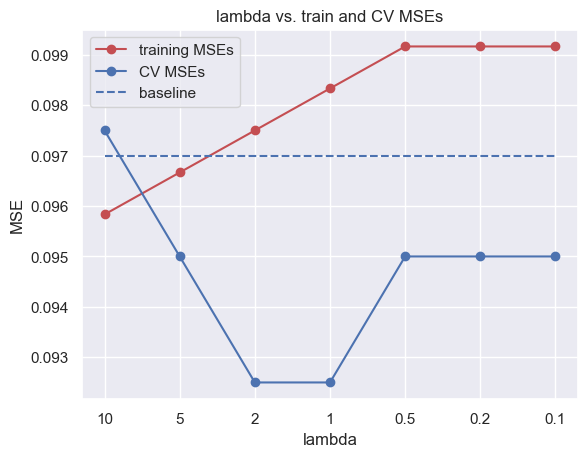

In [18]:
from sklearn.linear_model import RidgeClassifier
def train_plot_reg_params(reg_params, x_train, y_train, x_cv, y_cv, degree= 1, baseline=None):
    
    train_mses = []
    cv_mses = []
    models = []
    scalers = []

    # Loop over 10 times. Each adding one more degree of polynomial higher than the last.
    for reg_param in reg_params:

        # Add polynomial features to the training set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_train_mapped = poly.fit_transform(x_train)

        # Scale the training set
        scaler_poly = StandardScaler()
        X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
        scalers.append(scaler_poly)

        # Create and train the model
        model = RidgeClassifier(alpha=reg_param)
        model.fit(X_train_mapped_scaled, y_train)
        models.append(model)

        # Compute the training MSE
        yhat = model.predict(X_train_mapped_scaled)
        train_mse = mean_squared_error(y_train, yhat) / 2
        train_mses.append(train_mse)

        # Add polynomial features and scale the cross-validation set
        poly = PolynomialFeatures(degree, include_bias=False)
        X_cv_mapped = poly.fit_transform(x_cv)
        X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

        # Compute the cross-validation MSE
        yhat = model.predict(X_cv_mapped_scaled)
        cv_mse = mean_squared_error(y_cv, yhat) / 2
        cv_mses.append(cv_mse)

    # Plot the results
    reg_params = [str(x) for x in reg_params]
    plt.plot(reg_params, train_mses, marker='o', c='r', label='training MSEs'); 
    plt.plot(reg_params, cv_mses, marker='o', c='b', label='CV MSEs'); 
    plt.plot(reg_params, np.repeat(baseline, len(reg_params)), linestyle='--', label='baseline')
    plt.title("lambda vs. train and CV MSEs")
    plt.xlabel("lambda"); 
    plt.ylabel("MSE"); 
    plt.legend()
    plt.show()

# Define lambdas to plot
reg_params = [10, 5, 2, 1, 0.5, 0.2, 0.1]

# Define degree of polynomial and train for each value of lambda
train_plot_reg_params(reg_params, x_train, y_train, x_cv, y_cv, degree= 4, baseline=0.097)

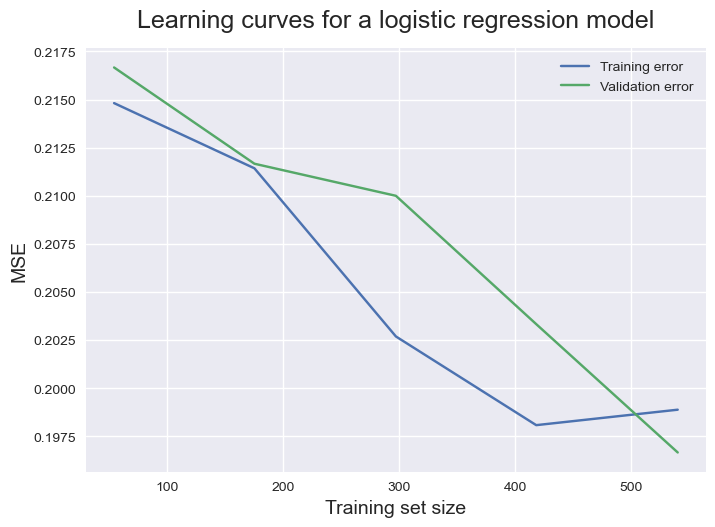

In [19]:
# train_sizes = [1, 200, 400, 600, 800]
train_sizes, train_scores, validation_scores = learning_curve(estimator = LogisticRegression(),
                                                              X = X_train_scaled, y = y_train, #train_sizes = train_sizes,
                                                              cv = 10, scoring = 'neg_mean_squared_error', shuffle=True)

train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error') 
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a logistic regression model', fontsize = 18, y = 1.03)
plt.legend(); plt.show()